Import packages and processed run metrics

In [34]:
# packages
import os
import re
import numpy as np
import pandas as pd

# source
helper = __import__('00_helper')

# control
write_files = 1
validation_metric = 'Results/val_acc'
project_names = [
    'femnist--s02', 'sst2', 'pubmed', 'pubmed2'#,
    #'cifar--alpha5.0', 'cifar--alpha0.5', 'cifar--alpha0.1'
]
df = helper.load_data(project_names)

## For CIFAR
# remove_methods = [
#     method for method in df.method.unique()
#     if method not in ['fedavg', 'exact']
# ]

# Custom sorts
from pandas.api.types import CategoricalDtype
cat_method_type = CategoricalDtype(
    [
        'ditto', 'fedbn', 'fedem', 'pfedme',  # pfl-methods
        'fomaml', 'fedavg', 'exact', 'linear'  # ml-methodsd
    ],
    ordered=True
)
cat_dataset_type = CategoricalDtype(
    [
        'femnist--s02', 'sst2', 'pubmed',
        'pubmed2'
    ],
    ordered=True
)


input datasets:
	 (681, 36)
	 (1320, 44)
	 (810, 37)
	 (185, 43)
all runs: (2996, 44)


In [35]:
def df_to_latex(
    df,
    id_columns,
    file_name=None,
    remove_columns=None,
    file_path='output'
):

    # remove columns not of interest
    if remove_columns is None:
        remove_columns = list()
    temp_df = df[[name for name in df.columns if name not in remove_columns]]

    # sort by id columns
    temp_df = temp_df.sort_values(by=id_columns)

    # create output file
    string_df = temp_df.to_string(
        header=True,
        index=False,
        index_names=False
    )

    # remove any leading space
    string_df = re.sub('^[\s]+', '', string_df)
    # remove leading space after newlines
    string_df = re.sub('\n[\s]+', '\n', string_df)
    # replace white space between words with table column skip
    string_df = re.sub('[ \t]+', ' & ', string_df)

    # add latex newline to end of each line
    string_df = string_df.replace('_', ' ')
    string_df = string_df.replace('\n', ' \\\\\n')
    string_df = string_df + ' \\\\'

    if file_name is not None:

        # write to file
        with open(os.path.join(file_path, f'{file_name}.txt'), 'w') as f:
            f.writelines(string_df)

    else:
        return string_df


Filter data to runs of interest
Apply summary function to filtered dataset

In [36]:
row_df = df
print('input dataset:', df.shape)

## row (run) filtering
# remove extra hyper-parameter searches

row_df = row_df.loc[(row_df.n_epochs < 6)]
print('\t reduce to 3 or fewer local update steps:', row_df.shape)

row_df = row_df.loc[(row_df.K < 6) | (row_df.method != 'pfedme')]
print('\t reduce to 3 or fewer local meta-learning steps for pfedme:', row_df.shape)

row_df = row_df.loc[((10 * row_df.beta).astype('Int64') % 2 == 0) | (row_df.method != 'exact')]
print('\t reduce beta grid for decay:', row_df.shape)

## column (metric) filtering
subset_df = row_df[[
    name for name in row_df.columns
    if (
        not re.search('^sys', name)
        and not re.search('f1', name)
        and not re.search('loss', name)
    )
]]

input dataset: (2996, 44)
	 reduce to 3 or fewer local update steps: (2310, 44)
	 reduce to 3 or fewer local meta-learning steps for pfedme: (2230, 44)
	 reduce beta grid for decay: (2133, 44)


In [37]:
## get best runs for each group
# regardless of finetuning
best_runs = subset_df.loc[
    subset_df.groupby(['dataset', 'method', 'finetune']) \
    [validation_metric].idxmax()  # return index of max validation metric
]
best_runs['method'] = best_runs['method'].astype(cat_method_type)
best_runs['dataset'] = best_runs['dataset'].astype(cat_dataset_type)

# treat finetuning groups as seperate
ft_yes = best_runs.loc[best_runs.finetune == 1]
ft_no = best_runs.loc[best_runs.finetune == 0]

# best_runs.loc[[method not in remove_methods for method in best_runs.method]].head(12)
best_runs.columns

Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/test_acc',
       'Results/test_acc_bottom_decile', 'Results/test_acc_std',
       'Results/val_acc', 'Results_unseen/test_acc',
       'Results_unseen/test_acc_bottom_decile', 'Results_unseen/test_acc_std',
       'Results_weighted/test_acc', 'Results_weighted_unseen/test_acc',
       'batch_size'],
      dtype='object')

For all best runs, regardless of finetuning, produce summaries

In [38]:
# For existing users, FT since sufficient data
seen_best_runs = ft_yes[[
    name for name in ft_yes.columns
    if (
        not re.search('weighted', name)
        and not re.search('unseen', name)
    )
    or (
        not re.search('Results', name)
        or re.search('val', name)
    )
]]

if write_files:
    helper.runs_to_latex(seen_best_runs, 'seen--ft_yes')

(seen_run_summary, seen_metric_summary, seen_rank_summary) = helper.process_run_metrics(seen_best_runs)
print('all runs:', seen_run_summary.shape)
print('all metrics:', seen_metric_summary.shape)


descending metrics: ['Results/test_acc', 'Results/test_acc_bottom_decile']

ascending metrics: ['Results/test_acc_std']

id_columns Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/val_acc', 'batch_size'],
      dtype='object')
all runs: (8, 4)
all metrics: (3, 4)


In [39]:
# run summary
seen_run_summary.sort_values(by='value', ascending=False)

,,rank_one_ind,rank_two_ind,rank_three_ind,value
method,finetune,,,,
ditto,1,2,1,4,7
fedbn,1,2,5,0,7
fedem,1,1,2,2,5
pfedme,1,3,0,2,5
fomaml,1,2,1,1,4
exact,1,1,3,0,4
fedavg,1,1,1,1,3
linear,1,1,0,2,3


View processed summaries

In [40]:
# metrics summary
sort_by = ['value', 'rank_one_ind', 'rank_two_ind', 'rank_three_ind']
seen_metric_summary.sort_values(by=sort_by, ascending=False)

,rank_one_ind,rank_two_ind,rank_three_ind,value
metric,,,,
Results/test_acc_bottom_decile,2,2,2,2
Results/test_acc,1,1,1,1
Results/test_acc_std,1,1,1,1


Now seperately, based on finetuning status, repeat the above summary

In [41]:
unseen_best_runs = best_runs[[
    name for name in ft_yes.columns
    if (
               not re.search('weighted', name)
               and re.search('unseen', name)
       )
       or (
               not re.search('Results', name)
               or re.search('val', name)
       )
]]

In [42]:
ft_yes = unseen_best_runs.loc[unseen_best_runs.finetune == 1]
(yes_run_summary, yes_metric_summary, _) = helper.process_run_metrics(ft_yes)
if write_files:
    helper.runs_to_latex(ft_yes, 'unseen--ft_yes')


descending metrics: ['Results_unseen/test_acc', 'Results_unseen/test_acc_bottom_decile']

ascending metrics: ['Results_unseen/test_acc_std']

id_columns Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/val_acc', 'batch_size'],
      dtype='object')


In [43]:
# run summary
yes_run_summary.sort_values(by='value', ascending=False)

,,rank_one_ind,rank_two_ind,rank_three_ind,value
method,finetune,,,,
exact,1,7,0,2,9
linear,1,2,3,1,6
fomaml,1,0,2,3,5
fedavg,1,1,3,0,4
fedbn,1,0,2,1,3
fedem,1,0,1,2,3
pfedme,1,0,3,0,3
ditto,1,0,0,0,0


In [44]:
# metrics summary
yes_metric_summary.sort_values(by=sort_by, ascending=False)


,rank_one_ind,rank_two_ind,rank_three_ind,value
metric,,,,
Results_unseen/test_acc,4,4,4,4
Results_unseen/test_acc_bottom_decile,3,3,3,3
Results_unseen/test_acc_std,2,2,2,2


ft_no = unseen_best_runs.loc[unseen_best_runs.finetune == 0]
(no_run_summary, no_metric_summary, _) = helper.process_run_metrics(ft_no)
if write_files:
    helper.runs_to_latex(ft_no, 'unseen--ft_no')

# run summary
no_run_summary.sort_values(by='value', ascending=False)

# metrics summary
no_metric_summary.sort_values(by=sort_by, ascending=False)

Temporary - Generalization

In [45]:
id_columns = ['method', 'finetune', 'dataset']
metrics = ['Results/test_acc','Results_unseen/test_acc']
temp = best_runs[id_columns + metrics]
temp[metrics] = temp[metrics].round(4)
temp['generalization_gap'] = temp['Results_unseen/test_acc'] - temp['Results/test_acc']
temp = temp.loc[temp.finetune == 1]

s = df_to_latex(temp, id_columns)
print(s)

method & finetune & dataset & Results/test acc & Results unseen/test acc & generalization gap \\
ditto & 1 & femnist--s02 & 0.9031 & 0.5672 & -0.3359 \\
ditto & 1 & sst2 & 0.5949 & 0.4746 & -0.1203 \\
ditto & 1 & pubmed & 0.8754 & 0.2442 & -0.6312 \\
ditto & 1 & pubmed2 & 0.8861 & 0.4873 & -0.3988 \\
fedbn & 1 & femnist--s02 & 0.9182 & 0.9059 & -0.0123 \\
fedbn & 1 & sst2 & 0.7360 & 0.8030 & 0.0670 \\
fedbn & 1 & pubmed & 0.8788 & 0.8004 & -0.0784 \\
fedbn & 1 & pubmed2 & 0.8777 & 0.7020 & -0.1757 \\
fedem & 1 & femnist--s02 & 0.8952 & 0.9175 & 0.0223 \\
fedem & 1 & sst2 & 0.7808 & 0.7404 & -0.0404 \\
fedem & 1 & pubmed & 0.8822 & 0.7879 & -0.0943 \\
fedem & 1 & pubmed2 & 0.8569 & 0.7977 & -0.0592 \\
pfedme & 1 & femnist--s02 & 0.9280 & 0.9036 & -0.0244 \\
pfedme & 1 & sst2 & 0.7699 & 0.7785 & 0.0086 \\
pfedme & 1 & pubmed & 0.8666 & 0.7932 & -0.0734 \\
pfedme & 1 & pubmed2 & 0.8631 & 0.8001 & -0.0630 \\
fomaml & 1 & femnist--s02 & 0.8951 & 0.8989 & 0.0038 \\
fomaml & 1 & sst2 & 0.7654

C:\Users\joela\AppData\Local\Temp\ipykernel_27752\140728881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[metrics] = temp[metrics].round(4)
C:\Users\joela\AppData\Local\Temp\ipykernel_27752\140728881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['generalization_gap'] = temp['Results_unseen/test_acc'] - temp['Results/test_acc']


Temporary - Sensitivity Analysis

In [46]:
exact_df = row_df.loc[
    (subset_df.method == 'exact')
    & (subset_df.n_epochs <= 3)
    & (subset_df.finetune == 1)
]

exact_df.groupby(['dataset', 'beta']) \
    [validation_metric].idxmax()  # return index of max validation metric


dataset       beta
femnist--s02  0.0      656
              0.2      649
              0.4      635
              0.6      628
              0.8      616
              1.0      677
pubmed        0.0     2786
              0.2     2187
              0.4     2147
              0.6     2105
              0.8     2066
              1.0     2804
pubmed2       0.0     2987
              0.2     2983
              0.4     2977
              0.6     2973
              0.8     2968
              1.0     2993
sst2          0.0     1936
              0.2      945
              0.4     1011
              0.6      905
              0.8      888
              1.0     1997
Name: Results/val_acc, dtype: int64

(24, 44)


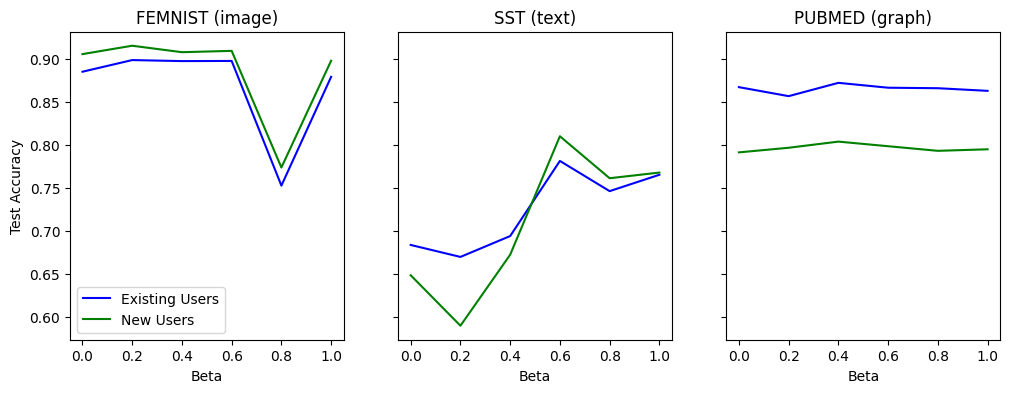

In [47]:
best_beta = exact_df.loc[
    exact_df.groupby(['dataset', 'beta']) \
        [validation_metric].idxmax()  # return index of max validation metric
].sort_values(by=['dataset', 'beta'])
print(best_beta.shape)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# best beta
datasets = ['femnist--s02', 'sst2', 'pubmed']
Datasets = ['FEMNIST (image)', 'SST (text)', 'PUBMED (graph)']

fig, axarr = plt.subplots(
    nrows=1, ncols=len(datasets),
    sharex=True, sharey=True,
    figsize=(4*len(datasets), 4)
)
axarr[0].set_ylabel('Test Accuracy')
for i, (dataset, Dataset) in enumerate(zip(datasets, Datasets)):
    temp_df = best_beta.loc[best_beta.dataset == dataset]
    axarr[i].set_title(Dataset)
    axarr[i].set_xlabel('Beta')
    axarr[i].plot(temp_df.beta, temp_df['Results/test_acc'], color='blue')
    axarr[i].plot(temp_df.beta, temp_df['Results_unseen/test_acc'], color='green')

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='green')
]
custom_labels = [
    'Existing Users',
    'New Users'
]
axarr[0].legend(
    custom_lines, custom_labels,
    loc='lower left'#,
    #bbox_to_anchor=(1, -.15),
    #ncol=len(datasets)
)

if write_files:
    plt.savefig('figures/sensitivity-analysis-best-beta.png')